# Find the correct action according to text query (command)

Our issue is to find an action that is coherent with a command that is given to the model. How to find a correct answer ? Let's take the example of Alexa. Alexa probably uses a neural-network model in order to get a coherent response. This can work with huge neural networks on cloud-driven architectures. However, on a simpler architecture, it may seem harder to do so. 



## Method 1: Incremental database learning

This method uses a command database in order to find the adequate answer. The user will give a command string to the model and the model will have to answer. If the answer is not what the user wants, then the user associates an action to his command and the database is updated.

![](commands-doc/IDL-flow1.svg)

### Query preprocessing

The goal here is to clean the query from unnecessary words (such as articles).

In [1]:
import time

def remove_punctuation_and_cap(query: str) -> str:
    return query.replace(",", "").replace(".", "").lower()
            
def remove_stopwords(query: str, words: set) -> list:
    processed_list = list()
    
    for word in query.split():
        if word not in words:
            processed_list.append(word)
            
    return processed_list

def prepare_query(query: str, words: set) -> list:
    
    start = time.time()

    query = remove_punctuation_and_cap(query)
            
    return remove_stopwords(query, words)

print(prepare_query("le elijah, éteins la télévision le le", ["elijah", "la", "le", "cette"]))

['éteins', 'télévision']


## How to modelize the data ?

### Naive representation

The data could be modelized as a word list from a query and as a response string. These word lists would be hashed in order to be stored. The hash should have low-dispersion in order for queries to be close to each other when they share the same semantics

![](commands-doc/data-storage.svg)

### Vectorizing the words

Another solution would be to vectorize the words before. With this, we could be able to classify words, which would be quite useful. Classes would represent the answer that the model would give to the user. Thanks to this classification, we could say "This vector has xx% of chances to match the question". Database selection could be done with the distance to the barycenter of the topics.

![](commands-doc/data-storage2.svg)

## Searching

### Naive search

The easiest version should be to compare query hashes. This is easy to implement but quite inefficient with highly-changing commands. As a consequence, using this search method is not advised as the user would have to put a lot of different commands' aliases when the model could guess what the user wants.

### Vector-based search

The challenge here is to give a value to each word in order to build a vector. This said vector is going to be transformed in a scalar value with a barycenter computation.

#### Naive method

We keep each word in memory and assign a random weight to them. When a vector is computed, we look in this table. Consistency is then kept, however, we can't be sure that it is going to be coherent and efficient, especially with new values...

##### Implementation

Those values must be initialized for the words below

In [2]:
import random
import numpy as np

barycenter_list = list()
word_map = dict() # map < String, int >

known_words = set(["télévision", "allumer", "éteindre"])

max_range = 200

for word in known_words:
    word_map[word] = (random.randrange(-max_range, max_range))/max_range

##### Computation

In [3]:
def valuation(word : str) -> float:
    if word in word_map:
        return word_map[word]
    word_map[word] = (random.randrange(-max_range, max_range))/max_range
    return word_map[word]

print(valuation("télévision"))
print(valuation("Poupipou"))

-0.33
-0.75


For each word in the sentence (that has been cleaned), a valuation is associated to it and put in the vector.

In [4]:
def vectorize(sentence : list) -> np.array:
    v = np.zeros((1, len(sentence)))
    
    for i, word in enumerate(sentence):
        v[0][i] = valuation(word)
    
    return v

In [5]:
%%script false --no-raise-error
# ^ Prevents execution
sentence = "Elijah, allume la télévision"
stoplist = ["elijah", "le", "la", "de", "?", "du", "les"]
words = prepare_query(sentence, stoplist)


v1 = vectorize(prepare_query("Elijah, allume la télévision", stoplist))
v2 = vectorize(prepare_query("Elijah, éteins la télévision", stoplist))
v3 = vectorize(prepare_query("Elijah, allume la télé", stoplist))
v4 = vectorize(prepare_query("Elijah, éteins la télé", stoplist))

print(np.linalg.norm(v1 - v2))
print(np.linalg.norm(v1 - v3))
print(np.linalg.norm(v1 - v4))
print(np.linalg.norm(v2 - v3))
print(np.linalg.norm(v2 - v4))
print(np.linalg.norm(v3 - v4))

#### Using new rules

As expected, since values are chosen randomly, similar words can't be linked together and give values that are very different. 
In order to link new words with older words, a distance needs to be computed.
There are three types of word:
- **New words**, that have nothing to do with the others
    - These words need to have a random value
- **Abreviated words**
    - These words must have the same value as the word they represent.
- **Alternative words**
    - These words need not to change the barycenter of the class they belong.
    - To simplify things, alternative words will follow abreviated words' rules.
    
    
##### How to find synonyms ?

Usage of a synonym structure (hashed map) and a set of base words

![](commands-doc/synonyms.svg)

This structure should be filled by an API (synonymes.net ?)




In [6]:
base_words = set(["allumer", "éteindre", "télévision"])

synonyms_dict = {
    "allumer": [],
    "éteindre": [],
    "télévision": ["télé", "écran"],
    "télé": ["télévision"],
    "écran" : ["télévision"]
}

Checking if the word is an abreviation or a synonym of another. Basically, an abreviate is a synonym. There is no use of the first function anymore, but we'll keep it for the sake of it.

In [7]:
def abreviate(word: str) -> str:
    
    for ws in set(word_map.keys()):
        if word in ws: # if the word is a substring of a key
            return ws
    
    return None

def synonym(word: str) -> str: 
    
    if word in base_words:
        return word
    
    if word in set(synonyms_dict.keys()):
        return synonyms_dict[word][0]
    
    # Find possible synonyms here and put 
    # 
    
    return None

New valuation calculation

In [8]:
def valuation(word : str) -> float:
    if word in word_map: # Word exists
        return word_map[word]
    
    # New word
    
    abrev = abreviate(word)
    syn  = synonym(word)
    
    if abrev: # The word is a synonym
        word_map[word] = word_map[abrev]
        return word_map[abrev]
        
    elif syn: # The word is an abreviation
        word_map[word] = word_map[syn]
        return word_map[syn]
        
    # the word is completely new
    word_map[word] = (random.randrange(-max_range, max_range))/max_range
    return word_map[word]

print(valuation("télévision"))
print(valuation("télé"))
print(valuation("écran"))

-0.33
-0.33
-0.33


In [9]:
sentence = "Elijah, allume la télévision"
stoplist = ["elijah", "le", "la"]
words = prepare_query(sentence, stoplist)


v1 = vectorize(prepare_query("Elijah, allume la télévision", stoplist))
v2 = vectorize(prepare_query("Elijah, éteins la télévision", stoplist))
v3 = vectorize(prepare_query("Elijah, allume la télé", stoplist))
v4 = vectorize(prepare_query("Elijah, éteins la télé", stoplist))

print(np.linalg.norm(v1 - v2))
print(np.linalg.norm(v1 - v3))
print(np.linalg.norm(v1 - v4))
print(np.linalg.norm(v2 - v3))
print(np.linalg.norm(v2 - v4))
print(np.linalg.norm(v3 - v4))

0.6000000000000001
0.0
0.6000000000000001
0.6000000000000001
0.0
0.6000000000000001


##### Binding an answer to a vector

In [10]:
answers = dict()

def bind_vector(sentence_vector : np.array, answers : dict, ans : str):
    answers[ans] = np.round(np.linalg.norm(sentence_vector), 2)
    
def bind_question(question: str, answers : dict, ans : str):
    vec = vectorize(prepare_query(question, stoplist))
    bind_vector(vec, answers, ans)

bind_question("Allume la télévision", answers, "Ok. J'allume la télévision.")
bind_question("Éteins la télévision", answers, "Ok. J'éteins la télévision.")
bind_question("Quelle est la météo de demain", answers, "Voici la météo de demain : ")

print(answers)

{"Ok. J'allume la télévision.": 0.34, "Ok. J'éteins la télévision.": 0.75, 'Voici la météo de demain : ': 0.96}


##### Finding the most fitting answer. 

We are going to use a priority queue in order to sort the answers by their distance to the query vector.

In [11]:
class pqueue:
    
    def __init__(self):
        self.data = list() # (item, priority)
    
    def add(self, item, priority : float):
        l = len(self.data)
        
        if l == 0:
            self.data.insert(0, (item, priority))
            return
        
        for i in range(l):
            if self.data[i][1] > priority:
                self.data.insert(i, (item, priority))
                return
                
        self.data.insert(l, (item, priority))
        
    def __str__(self):
        s = ""
        
        if len(self.data) == 0:
            return "Empty queue"
        
        for item in self.data:
            s += str(item) + " "
        return s
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        return self.data[item]
        

In [12]:
%%script false --no-raise-error
# pqueue test
q = pqueue()
q.add("hello", 2)
q.add("hi", 4)
q.add("bonjour", -1)


print(q)

del q

In [13]:
def find_answers(query: str, answers : dict) -> (pqueue, float):
    q = pqueue()
    
    v = vectorize(prepare_query(query, stoplist))
    v = np.round(np.linalg.norm(v) ,3)
    
    psum = 0
    
    for ans, barycenter in answers.items():
        priority = np.round(abs(barycenter - v), 3)
        psum += priority
        
        q.add(ans, priority)
    
    return q, psum
        
result = find_answers("Allume la télé", answers)

print(result[0])
print(result[1])

("Ok. J'allume la télévision.", 0.002) ("Ok. J'éteins la télévision.", 0.412) ('Voici la météo de demain : ', 0.622) 
1.036


##### Selecting closest answer

In [14]:
answer_threshold = 1

def select_answer(q : pqueue, threshold = answer_threshold) -> str:
    if q[0][1] > threshold:
        return "I did not understand the question"
    return q[0][0]
    
select_answer(result[0])

"Ok. J'allume la télévision."

##### Analyzing answer space

Our space is a line. That means that all our answers are positionned on a line, which makes the space very limited.

['éteindre', 'allumer', 'télévision', 'Poupipou', 'télé', 'écran', 'allume', 'éteins', 'quelle', 'est', 'météo', 'de', 'demain']
[0.76, -0.075, -0.33, -0.75, -0.33, -0.33, -0.075, -0.675, -0.31, 0.565, -0.14, -0.42, 0.55]


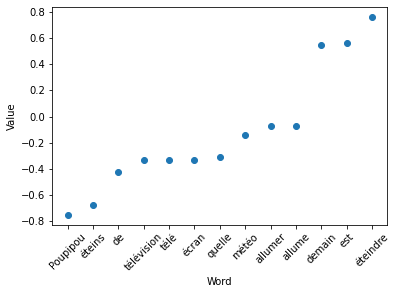

In [15]:
import matplotlib.pyplot as plt

x = list(word_map.keys())
y = list(word_map.values())

xs = list()
ys = list()

print(x)
print(y)

q = pqueue()

for i in range(len(x)):
    q.add(x[i], y[i])
    
for i in range(len(x)):
    xs.append(q[i][0])
    ys.append(q[i][1])

plt.scatter(xs, ys)
plt.xlabel("Word")
plt.ylabel("Value")

plt.xticks(rotation=45)

plt.show()

As we can see, this way of representing data does not work. Some values that are unrelated have neighboring values, which makes it quite difficult to evaluate.

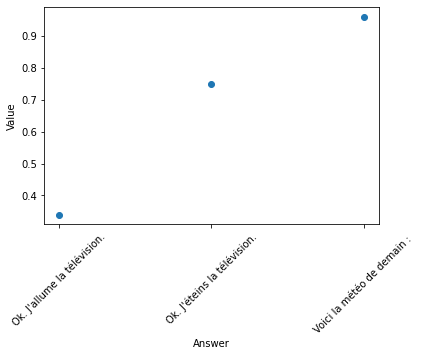

In [16]:
x = list(answers.keys())
y = list(answers.values())

xs = list()
ys = list()

q = pqueue()

for i in range(len(x)):
    q.add(x[i], y[i])
    
for i in range(len(x)):
    xs.append(q[i][0])
    ys.append(q[i][1])

plt.scatter(xs, ys)
plt.xlabel("Answer")
plt.ylabel("Value")

plt.xticks(rotation=45)

plt.show()

The answer space might be even worse and it could be really tight to determine the right answers, depending on the word value randomization. Thus, this method cannot be used in order to solve this problem.

#### Use of bag of words

The principle of bag of words is to associate to a sentence an array of integers representing the histogram of the words used in the sentence. It needs a "dictionnary", a set of words that will be available in the bag of words.

![](commands-doc/bag-of-words.svg)

In [17]:
class bag_of_words:
    
    def __init__(self):
        self.dictionnary = set()
        self.order = dict()
        
        
    def update(self, sentence: list): # Update BoW contents
        for word in sentence:
            if word not in self.dictionnary:
                self.order[word] = len(self)
                self.add(word)
                
    def define(self, vocabulary : list): # Define BoW contents
        for sentence in vocabulary:
            self.update(sentence)
                    

    
    def add(self, word : str): 
        self.dictionnary.add(word)
                
    def new(self, sentence : list) -> np.array:
        
        self.update(sentence)
        bag = np.zeros((len(self)), dtype=int)
        
        for word in sentence:
            if word not in self.dictionnary:
                raise Exception(f"Warning: undefined token `{word}` in the bag of words.")
            
            index = self.order[word]
            bag[index] += 1
    
        
        return bag
        
        
    def __str__(self):
        return self.dictionnary
            
    def __len__(self):
        return len(self.dictionnary)
        

In [18]:
bow = bag_of_words()

s1 = prepare_query("Allume la télévision de la chambre", stoplist)
s2 = prepare_query("Allume la télé du salon", stoplist)
s3 = prepare_query("Elijah, éteins le toaster", stoplist)

s4 = prepare_query("Elijah, rallume la télévision", stoplist)
# Define bow words
bow.define([s1, s2, s3])

b1 = bow.new(s1)
b2 = bow.new(s2)
b3 = bow.new(s3)

b4 = bow.new(s4)

print(b1)
print(b2)
print(b3)
print(b4)



[1 1 1 1 0 0 0 0 0]
[1 0 0 0 1 1 1 0 0]
[0 0 0 0 0 0 0 1 1]
[0 1 0 0 0 0 0 0 0 1]


Now that the bag of word is working, we can try and see if this could work. The new verification method should be the following.

![](commands-doc/bow-check.svg)

In [19]:
def distance(v1 : np.array, v2: np.array) -> int:
    
    """
    Computes a difference vector of dim = max(v1, v2), then returns its norm
    """
    
    m = max(len(v1), len(v2))
    
    w1 = np.zeros(m)
    w2 = np.zeros(m)
    
    w1[:len(v1)] = v1
    w2[:len(v2)] = v2
    
    return (np.abs(w1 - w2)).sum()

def similitude(v1 : np.array, v2 : np.array) -> float:
    m = max(len(v1), len(v2))
    return (m - distance(v1, v2))/m * 100

print(distance(b1, b1))
print(distance(b1, b2))
print(distance(b1, b3))
print(distance(b2, b3))
print(distance(b1, b4))

print("=====")

print(similitude(b1, b1))
print(similitude(b1, b2))
print(similitude(b1, b3))
print(similitude(b2, b3))
print(similitude(b1, b4))

0.0
6.0
6.0
6.0
4.0
=====
100.0
33.33333333333333
33.33333333333333
33.33333333333333
60.0


There's an issue with this way of computing the distance. For elements that are really close grammatically but not semantically, their distance is close too but shouldn't.

For example if v1 = "Allume la télévision"

|v2|Distance|
|--|--------|
|"Allume la télévision"|0|
|"Allume la télé"|1|
|"Allume la chambre"|1|
|"Éteins la télé"|2|

For the second one, "Allume la chambre" shouldn't be as close as "Allume la télé" since it's not referring as the same object, whereas "télé" refers to "télévision".

#### Use of the stemming algorithm

A solution to this issue would be to use a stemming algorithm in order to limit the vocabulary of the bag of words. 

This algorithm would detect if the word that has to be added to the vocabulary or not. These words would be added in a map in order to be faster.

In [20]:
class stemmer:
    
    def __init__(self, map_replace : dict = None):
        if map_replace == None:
            self.map_replace = dict()
            self.known_words = set()
        else:
            self.map_replace = map_replace.copy()
            for word in map_replace.keys():
                self.known_words.add(word)
                
    def add(self, stem: str):
        self.map_replace[stem] = stem
        self.known_words.add(stem)
        
    def stem(self, word:str) -> str:
        
        if word in self.known_words: # Stem already found OR synonym
            return self.map_replace[word]
        
        for end in range(len(word)): # Testing substrings
            if word[:end] in self.known_words: # Found stem
                
                self.map_replace[word] = word[:end]
                return self.map_replace[word[:end]]
        
        # Returns the word but does not place it automatically as a stem
        # since it could not be one.
        
        return word
                
        
    def __str__(self):
        return str(self.map_replace)

At this point of the modelization, this seems pretty overkill.
We'll focus now on an easier modelization for now

## Method 2: Dynamic dispatch

In this modelization, we will use a two-tier architecture to manage queries.

![](commands-doc/association-rules.svg)

The first level of the architecture is the action dispatcher. This level will select the action to do according to the query. 
It will then pass the query to the according actuator, which will analyze the query to find the action to do. The actuator is a strategy design pattern in order to run the correct algorithms.

![](commands-doc/actuator.svg)


In [21]:
class ActuatorStrategy:
    def __init__(self):
        raise Exception("Virtual class")
    
    def analyze(self, query : list) -> dict:
        raise Exception("Not implemented")
        
    def do(self, query: list) -> str:
        raise Exception("Not implemented")
     

In [22]:
class On(ActuatorStrategy):
    def __init__(self):
        pass
    
    def analyze(self, query: list) -> dict:
        print("analyze ON")
        return
    
    def do(self, query: list) -> str:
        print("do ON")
        return

In [23]:
class Off(ActuatorStrategy):
    def __init__(self):
        pass
    
    def analyze(self, query: list) -> dict:
        print("analyze OFF")
        return
    
    def do(self, query: list) -> str:
        print("do OFF")
        return

In [24]:
class Weather(ActuatorStrategy):
    def __init__(self):
        pass
    
    def analyze(self, query: list) -> dict:
        print("analyze WEATHER")
        return
    
    def do(self, query: list) -> str:
        print("do WEATHER")
        return

In [25]:
class UnknownAction(ActuatorStrategy):
    def __init__(self):
        pass
    
    def analyze(self, query: list) -> dict:
        return None
    
    def do(self, query: list) -> str:
        return "Sorry, I did not understand"

Now that the strategies are defined, we can call them depending on the context. Here's how the dispatcher works.
The first level will try to decide of an action correlated with the query. It will then associate the strategy known for the action found. Then, it calls the found strategy with the parameters needed.

![](commands-doc/dispatcher_internal.svg)

In [34]:
import enum

class Action(enum.Enum):
    UNKNOWN = 0,
    ON = 1,
    OFF = 2,
    WEATHER = 3

class action_dispatcher:
    
    def __init__(self, query_action_map : dict = None, action_function_map : dict = None):
        
        if query_action_map == None:
            self.queries = dict()
        else:
            self.queries = query_action_map 
            
        if action_function_map == None:
            self.actions = dict()
        else:
            self.actions = action_function_map
            
    def bind_word_to_action(self, word: str, action: enum.Enum):
        self.queries[word] = action
    
    def bind_action_to_method(self, action: enum.Enum, method: ActuatorStrategy):
        self.actions[action] = method
        
    def dispatch(self, query: str) -> ActuatorStrategy:
        qlist = prepare_query(query, stoplist)
        
        keywords = set(self.queries.keys())
        strategy = self.actions[Action.UNKNOWN]
        
        for word in qlist:
            if word in keywords:
                strategy = self.actions[self.queries[word]]
                break
        
        handler = strategy()
        return handler.do(qlist)
        
query_action_map = {"allumer" : Action.ON, "allume" : Action.ON, "active" : Action.ON,
                   "éteins" : Action.OFF, "désactive" : Action.OFF, "éteindre" : Action.OFF, 
                   "météo" : Action.WEATHER, "température" : Action.WEATHER, "temps" : Action.WEATHER}

action_function_map = {Action.UNKNOWN: UnknownAction, Action.ON : On, Action.OFF : Off, Action.WEATHER : Weather}
    
a = action_dispatcher(query_action_map, action_function_map)

a.dispatch("allume la télévision")
a.dispatch("allume le toaster")
a.dispatch("éteins la chambre")
a.dispatch("quel temps fait-il demain ?")

do ON
do ON
do OFF
do WEATHER
